<a href="https://colab.research.google.com/github/Christianib003/water-quality-model/blob/Nicholas/Nicholas_Eke_water_quality_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FORMATIVE ASSIGNMENT II: WATER QUALITY MODEL

## 1. Introduction
**Assignment**: Building a Classification Model Using Neural Networks

**Objective:**
Develop a neural network-based classification model using a provided dataset, incorporating multiple optimization techniques and ensuring equitable group contribution.

**In this notebook, we will take the cleaned and imputed dataset and use it to train, test, and evaluate a deep learning model**:

The key steps we'll cover are:
1. Loading the preprocessed (imputed) dataset.
2. Separating features and the target variable.
3. Splitting the dataset into three distinct portions: training, validation, and testing sets. This is crucial for robust model development and evaluation.
4. Applying feature scaling (StandardScaler) correctly after the split to prevent data leakage.

**Note:** The data cleaning and imputation steps were performed in a previous notebook.
If you'd like to review that process, please refer to: [Data Preprocessing Notebook](data_preprocessing.ipynb).

**Model Details**


| Engineer Name     | Regularizer | Optimizer | Early Stopping  | Dropout Rate | Learning Rate |
| ----------------- | ---------------------------- | --------- | ------------------------------------------------ | ------------ | ------------- |
| Nicholas Eke | L1 (0.01)           | RMSprop      | val_loss, p = 5                    | 0.3         | 0.0005 rate        |



## 2. Feature Scaling
### 2.1 Declaring Utility Functions

In [38]:
# Install missing packages if needed
%pip install pandas scikit-learn

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads a CSV file into a pandas DataFrame.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame.

    Raises:
        TypeError: If file_path is not a string.
        FileNotFoundError: If the file specified by file_path is not found.
        Exception: For other pandas-related read errors.
    """
    if not isinstance(file_path, str):
        raise TypeError("file_path must be a string.")
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded dataset from: {file_path}")
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        raise Exception(f"Error reading CSV file '{file_path}': {e}")

In [40]:
# Display the first few rows of the dataset
# We verify the columns, data types, and ensure that our imputation worked
# All columns should have non-null counts matching the total number of entries.
def display_initial_info(df: pd.DataFrame):
    """
    Displays the first few rows and basic info of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to inspect.

    Raises:
        TypeError: If df is not a pandas DataFrame.
        ValueError: If df is None.
    """
    print("===============First 5 rows:===============")
    print(df.head())
    print("\n===============Information:===============")
    df.info()

In [41]:
def separate_features_target(df: pd.DataFrame, target_column: str) -> tuple[pd.DataFrame, pd.Series]:
    """
    Separates features and the target variable from a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to separate.
        target_column (str): The name of the target column.

    Returns:
        tuple[pd.DataFrame, pd.Series]: A tuple containing features (X) and target (y).

    Raises:
        TypeError: If df is not a DataFrame or target_column is not a string.
        ValueError: If df is None or target_column is not found in df.columns.
    """
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame columns: {df.columns.tolist()}")

    X = df.drop(columns=[target_column])
    y = df[target_column]
    print(f"\nFeatures (X) and target (y, column: '{target_column}') have been separated.")
    print(f"Shape of features (X): {X.shape}")
    print(f"Shape of target (y): {y.shape}")
    return X, y


In [42]:
def split_data(X: pd.DataFrame, y: pd.Series,
               test_size: float = 0.15,
               val_relative_to_train_val_size: float = 0.15 / 0.85,
               random_state: int = 42,
               stratify_data: bool = True) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits feature and target data into training, validation, and test sets.

    Args:
        X (pd.DataFrame): Features.
        y (pd.Series): Target variable.
        test_size (float): Proportion of the dataset to allocate to the test set.
        val_relative_to_train_val_size (float): Proportion of the (train+validation) set to allocate to validation.
        random_state (int): Seed for random number generator for reproducibility.
        stratify_data (bool): Whether to stratify the split based on the target variable y.

    Returns:
        tuple: X_train, X_val, X_test, y_train, y_val, y_test

    Raises:
        TypeError: If X is not a DataFrame or y is not a Series.
        ValueError: If X or y is None, or if shapes are incompatible.
    """
    if len(X) != len(y):
        raise ValueError(f"Shape mismatch: X has {len(X)} samples, y has {len(y)} samples.")

    stratify_option_main = y if stratify_data else None
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_option_main
    )

    stratify_option_tv = y_train_val if stratify_data else None
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_to_train_val_size,
        random_state=random_state, stratify=stratify_option_tv
    )

    print("\nData splitting completed.")
    return X_train, X_val, X_test, y_train, y_val, y_test

In [43]:
def scale_features(X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame) -> tuple[StandardScaler, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Fits StandardScaler on X_train and transforms X_train, X_val, X_test.

    Args:
        X_train (pd.DataFrame): Training features.
        X_val (pd.DataFrame): Validation features.
        X_test (pd.DataFrame): Test features.

    Returns:
        tuple: The fitted scaler object, and the scaled DataFrames (X_train_scaled, X_val_scaled, X_test_scaled).

    Raises:
        TypeError: If any input is not a pandas DataFrame.
        ValueError: If any input DataFrame is None.
    """
    for df_name, df_obj in [("X_train", X_train), ("X_val", X_val), ("X_test", X_test)]:
        if not isinstance(df_obj, pd.DataFrame):
            raise TypeError(f"Input '{df_name}' must be a pandas DataFrame. Got {type(df_obj)}.")
        if df_obj is None:
            raise ValueError(f"Input DataFrame '{df_name}' cannot be None.")

    scaler = StandardScaler()

    print("\nFitting StandardScaler on X_train...")
    # Ensure X_train has data (not empty) before fitting
    if X_train.empty:
        raise ValueError("X_train is empty, cannot fit StandardScaler.")
    scaler.fit(X_train) # Fit ONLY on training data
    print("Scaler fitted.")

    print("Transforming X_train, X_val, and X_test...")
    X_train_scaled_array = scaler.transform(X_train)
    X_val_scaled_array = scaler.transform(X_val)
    X_test_scaled_array = scaler.transform(X_test)
    print("Transformation complete.")

    # Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled_array, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)
    print("Scaled data converted back to DataFrames.")

    return scaler, X_train_scaled, X_val_scaled, X_test_scaled



### 2.2 Feature Scaling Implementation

In [44]:
# Here, we load the dataset that has already undergone cleaning and imputation.
# It's important to use the version where missing values have already been handled.
# Path to the file which has already missing fields handled
FILE_PATH_IMPUTED = "imputed_water_potability_data.csv"

# Load the dataset
df = load_data(FILE_PATH_IMPUTED)

# Display the overview of the dataset
display_initial_info(df)


Successfully loaded dataset from: imputed_water_potability_data.csv
===============First 5 rows:===============
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.036752  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  333.073546    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  333.073546    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  

===============Information:===============
<cl

In [45]:
# Separate features and target variable
X, y = separate_features_target(df, "Potability")


Features (X) and target (y, column: 'Potability') have been separated.
Shape of features (X): (3276, 9)
Shape of target (y): (3276,)


In [46]:
# Initialize split variables to None
X_train, X_val, X_test, y_train, y_val, y_test = [None] * 6

if X is not None and y is not None:
    try:
        X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, stratify_data=True)

        # Display proportions
        print(f"Shape of X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}")
        print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

        total_samples = len(X)
        print("\nProportion of samples in each set (approximate):")
        print(f"Training set: {len(X_train)/total_samples*100:.2f}%")
        print(f"Validation set: {len(X_val)/total_samples*100:.2f}%")
        print(f"Test set: {len(X_test)/total_samples*100:.2f}%")

    except TypeError as e:
        raise ValueError(f"TypeError during data splitting: {e}")
    except ValueError as e:
        raise ValueError(f"ValueError during data splitting: {e}")
else:
    raise ValueError("X or y is None.")


Data splitting completed.
Shape of X_train: (2292, 9), y_train: (2292,)
Shape of X_val: (492, 9), y_val: (492,)
Shape of X_test: (492, 9), y_test: (492,)

Proportion of samples in each set (approximate):
Training set: 69.96%
Validation set: 15.02%
Test set: 15.02%


In [47]:
scaler_object, X_train_scaled, X_val_scaled, X_test_scaled = [None] * 4

if X_train is not None and X_val is not None and X_test is not None:
    try:
        scaler_object, X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train, X_val, X_test)

        print("\n--- Verification of Scaled Training Data ---")
        display_initial_info(X_train_scaled)

        print("\nDescriptive statistics of X_train_scaled (mean ~0, std ~1):")
        print(X_train_scaled.describe().round(2))

        print("\nWorkflow complete. Data is prepared for model training.")
        print("Prepared data sets:")
        print(f"X_train_scaled: {X_train_scaled.shape}, y_train: {y_train.shape if y_train is not None else 'N/A'}")
        print(f"X_val_scaled: {X_val_scaled.shape}, y_val: {y_val.shape if y_val is not None else 'N/A'}")
        print(f"X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape if y_test is not None else 'N/A'}")

    except (TypeError, ValueError) as e:
        print(f"Error during feature scaling: {e}")
else:
    print("Skipping feature scaling as data splits are not available.")


Fitting StandardScaler on X_train...
Scaler fitted.
Transforming X_train, X_val, and X_test...
Transformation complete.
Scaled data converted back to DataFrames.

--- Verification of Scaled Training Data ---
===============First 5 rows:===============
            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
2766  0.292120  0.027566  0.522327     0.038376 -1.781081     -0.634797   
2505 -0.104021  0.816164 -0.481655     0.540023 -0.954435      0.033630   
163  -0.647064 -1.665957 -1.420733     0.308547 -1.555323     -0.140706   
43    1.961394  0.193955 -1.379953    -0.160524  0.108557     -1.163968   
2040 -0.022284  1.805507 -0.796542     0.846080  0.798238      0.565539   

      Organic_carbon  Trihalomethanes  Turbidity  
2766       -0.341967         0.209553  -0.180315  
2505       -0.619904         0.161566  -1.631684  
163         0.672902        -0.993148   0.866453  
43          2.973166         0.352298   0.939613  
2040        0.099535        -1.655482  -0

## 3. Building and Training a Model

...

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from sklearn.metrics import f1_score, recall_score, precision_score


In [49]:
# Define model architecture
def model_nicholas_eke():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01), input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [50]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [51]:
# Train model
model = model_nicholas_eke()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[callback],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5221 - loss: 794.1005 - val_accuracy: 0.6098 - val_loss: 203.9322
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5128 - loss: 399.8061 - val_accuracy: 0.6098 - val_loss: 73.2443
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5123 - loss: 198.5907 - val_accuracy: 0.6098 - val_loss: 10.3116
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5071 - loss: 71.0328 - val_accuracy: 0.6098 - val_loss: 2.7244
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5250 - loss: 29.5946 - val_accuracy: 0.6098 - val_loss: 2.3252
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5466 - loss: 10.9987 - val_accuracy: 0.6098 - val_loss: 2.1818
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5533 - loss: 6.5061 - val_accuracy: 0.6098 - val_loss: 2.0902
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - loss: 3.9779 - val_accuracy: 0.6098 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


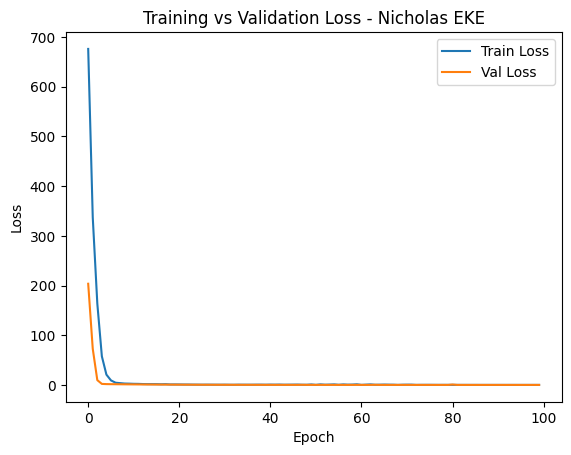

Classification Report for Nicholas EKE:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       300
           1       0.00      0.00      0.00       192

    accuracy                           0.61       492
   macro avg       0.30      0.50      0.38       492
weighted avg       0.37      0.61      0.46       492



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


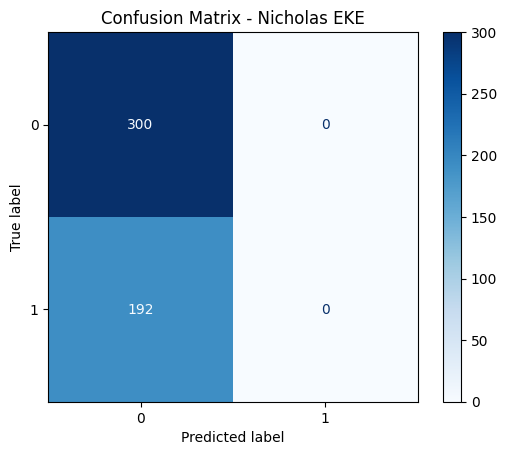

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Accuracy and Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss - Nicholas EKE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation Metrics
print("Classification Report for Nicholas EKE:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Nicholas EKE")
plt.show()

| Train Instance | Engineer Name | Regularizer | Optimizer | Early Stopping | Dropout Rate | Learning Rate | Accuracy | F1 Score | Recall | Precision |
| -------------- | ------------- | ----------- | --------- | -------------- | ------------ | ------------- | -------- | -------- | ------ | --------- |
| 1              | Nicholas EKE  | L1 (0.01)   | RMSprop   | val\_loss, P=5 | 0.3          | 0.0005        | 0.61     | 0.00     | 0.00   | 0.00      |


*REPORT*

 The final evaluation results from the test set are definitive and demonstrate that the neural network model, in its final configuration, has failed to learn any meaningful patterns from the data.

Metric Breakdown
Accuracy (0.6098):
This number is misleading if viewed in isolation. It almost perfectly matches the proportion of the majority class ("Not Potable") in the dataset. This indicates the model has achieved this accuracy not by intelligently classifying samples, but simply by defaulting to the most frequent prediction.

Precision, Recall, and F1 Score (all 0.0000 for Class 1, "Potable"):
This is the most critical finding. A score of zero across these three key metrics means the model completely failed to identify a single "Potable" water sample.

Zero Recall means that of all the actual potable samples in the test set, none were found.

Zero Precision means that on the rare occasion the model might have predicted "Potable" (which in this case was never), none would have been correct.


The report confirms the above. For the "Potable" class, all scores are zero. For the "Not Potable" class, the recall is 1.00, which confirms the model predicted every single sample as "Not Potable."

*Conclusion*
The model has collapsed into a "majority class classifier." It learned that the safest strategy to minimize its loss function was to ignore the input features entirely and always predict "Not Potable." This strategy is useless for any practical application.

The core reason for this failure, as evidenced by the repeated inability of the model to learn across various hyperparameter settings, is that the provided features (ph, Hardness, Solids, etc.) do not contain a strong enough predictive signal for this deep learning architecture to capture. The patterns are either: too weak, too complex in a way the model can't grasp, or non-existent, making it impossible for the model to distinguish between the two classes effectively.

